# Notebook for testing that proposed metric correlates with training loss of CTGAN and TVAE

A preliminary postulate of metaevaluation of new metrics is: The metric should correlate with improved quality of the synthetic data. 

Hence, in this notebook we will test if the proposed PCA metrics improve with the continued training of a generative model, viz. TVAE. I.e. if the model improve in their ability to model the training data, the metric should improve as well. 

In [1]:
### Setup
import numpy as np
import pandas as pd

np.random.seed(0)

### Data sets
data_dicts = [
    {'name': 'cardiotocography', 'data': pd.read_csv('data/cardiotocography_train.csv'), 'cat_cols': ['Class'], 'target_col': 'Class', 'epochs': 500, 'save_freq': 10, 'log_scaler': 100},
    {'name': 'diabetes', 'data': pd.read_csv('data/diabetes_train.csv'), 'cat_cols': ['Pregnancies', 'Outcome'], 'target_col': 'Outcome', 'epochs': 500, 'save_freq': 10, 'log_scaler': 0},
    {'name': 'iraq_heart', 'data': pd.read_csv('data/iraq_heart_train.csv'), 'cat_cols': ['Gender', 'Result'], 'target_col': 'Result', 'epochs': 1500, 'save_freq': 20, 'log_scaler': 10},
    {'name': 'mice_protein', 'data': pd.read_csv('data/mice_protein_train.csv'), 'cat_cols': ['Genotype', 'Treatment', 'Behavior', 'class'], 'target_col': 'class', 'epochs': 500, 'save_freq': 10, 'log_scaler': 80},
]

### Experiment settings
Z = 1.96
NUM_EXPERIMENTS = 10

## Behaviour during TVAE training

In [2]:
### Full experiment for TVAE
import os
import torch

import pandas as pd

from ctgan import TVAE
from syntheval import SynthEval

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

def run_experiment(data_in, epochs, save_freq, id):
    df_train, cat_cols, target_col = data_in
    
    tvae = TVAE(epochs=epochs)
    tvae.fit(df_train, cat_cols, checkpoints=save_freq, idx=id)

    epoch, loss = [], []
    pca_eigval_diff, pca_eigvec_ang, pca_eigvec_nul = [], [], []

    SE = SynthEval(df_train, cat_cols=cat_cols, verbose=False)

    for i in range(int(epochs/save_freq)):
        model = torch.load(f'saved_models/tvae_decoder_epoch_{(i+1)*save_freq}_{id}.pt')
        tvae.decoder.load_state_dict(model)

        df_syn = tvae.sample(len(df_train))

        res = SE.evaluate(df_syn, analysis_target_var=target_col, pca={'preprocess':'mean'})

        epoch.append((i+1)*save_freq)
        loss.append(tvae.loss_values.iloc[(i)*save_freq]['Loss'])
        pca_eigval_diff.append(res['val'][0])
        pca_eigvec_ang.append(res['val'][1])

        os.remove(f'saved_models/tvae_decoder_epoch_{(i+1)*save_freq}_{id}.pt')
    
    return pd.DataFrame({'epoch': epoch, 'dec_loss': loss, 'pca_eigval_diff': pca_eigval_diff, 'pca_eigvec_ang': pca_eigvec_ang})

for data_dict in data_dicts:
    res_list = Parallel(n_jobs=-3)(delayed(run_experiment)((data_dict['data'], data_dict['cat_cols'], data_dict['target_col']), data_dict['epochs'], data_dict['save_freq'], i) for i in tqdm(range(NUM_EXPERIMENTS)))
    data_dict['res_list'] = res_list


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

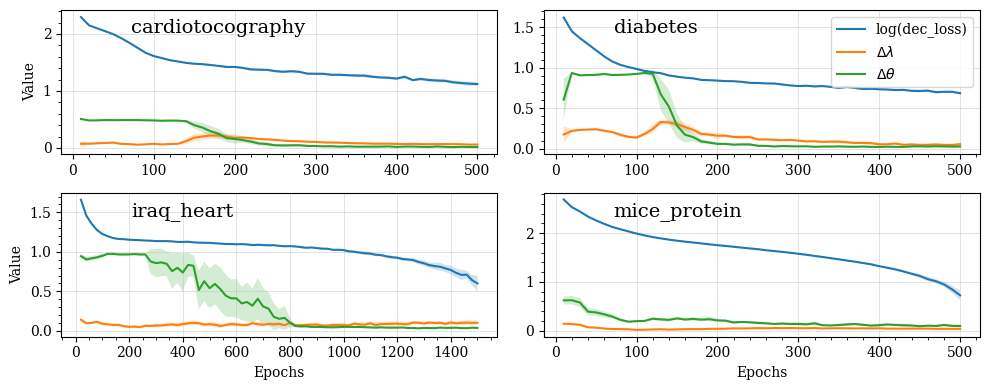

In [ ]:
### FIGURE 3 in our paper 
import matplotlib.pyplot as plt

from scipy.stats import sem

rcp = {'font.size': 10, 'font.family': 'serif'}
plt.rcParams.update(**rcp)

fig, axes = plt.subplots(2, 2, figsize=(10, 4))

for ax, data_dict in zip(axes.flat, data_dicts):
    # Extract the data from res_list
    epochs = data_dict['res_list'][0]['epoch']
    dec_loss = [np.log10(res['dec_loss']+data_dict['log_scaler']) for res in data_dict['res_list']]
    dL = [res['pca_eigval_diff'] for res in data_dict['res_list']]
    dT = [res['pca_eigvec_ang'] for res in data_dict['res_list']]

    # Calculate the confidence intervals
    dec_loss_mean = np.mean(dec_loss, axis=0)
    dec_loss_sem = Z*sem(dec_loss, axis=0)
    dL_mean = np.mean(dL, axis=0)
    dL_sem = Z*sem(dL, axis=0)
    dT_mean = np.mean(dT, axis=0)
    dT_sem = Z*sem(dT, axis=0)

    # Plot the lineplots
    ax.plot(epochs, dec_loss_mean, label='log(dec_loss)')
    ax.fill_between(epochs, dec_loss_mean - dec_loss_sem, dec_loss_mean + dec_loss_sem, alpha=0.2)
    ax.plot(epochs, dL_mean, label=r'$\Delta \lambda$')
    ax.fill_between(epochs, dL_mean - dL_sem, dL_mean + dL_sem, alpha=0.2)
    ax.plot(epochs, dT_mean, label=r'$\Delta \theta$')
    ax.fill_between(epochs, dT_mean - dT_sem, dT_mean + dT_sem, alpha=0.2)

    ax.minorticks_on()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5',alpha=0.5)

    ax.text(0.16, 0.84, data_dict['name'], fontsize=14, transform=ax.transAxes)

axes[0,0].set_ylabel('Value')
axes[1,0].set_ylabel('Value')

axes[1,0].set_xlabel('Epochs') 
axes[1,1].set_xlabel('Epochs')
    
axes[0,1].legend()
plt.tight_layout()

# fig.savefig('tvae_loss.pdf')

plt.show()

In [4]:
data_dicts[0]['res_list']

[    epoch    dec_loss  pca_eigval_diff  pca_eigvec_ang
 0      10  110.137535         0.162457        0.514453
 1      20   41.519817         0.053707        0.486901
 2      30   27.760736         0.095674        0.488833
 3      40   16.090645         0.115020        0.472543
 4      50    0.093009         0.113727        0.487578
 5      60  -14.673994         0.061446        0.484546
 6      70  -25.374933         0.068540        0.495497
 7      80  -42.036564         0.056210        0.485226
 8      90  -49.192928         0.061183        0.464147
 9     100  -57.967899         0.141419        0.476263
 10    110  -58.388744         0.067754        0.443483
 11    120  -61.548035         0.078470        0.419305
 12    130  -65.946854         0.102094        0.443976
 13    140  -66.419022         0.060850        0.434958
 14    150  -68.370819         0.076225        0.436576
 15    160  -67.978630         0.116604        0.455377
 16    170  -69.326408         0.055516        0

In [1]:
### Short bit for saving a couple of datasets
import os
import torch
import pandas as pd

from ctgan import TVAE

df_train = pd.read_csv('data/cardiotocography_train.csv')

cat_cols = ['Class']
target_col = 'Class'

tvae = TVAE(epochs=501)
tvae.fit(df_train, cat_cols, checkpoints=100, idx=0)

for i in [500]:
    model = torch.load(f'saved_models/tvae_decoder_epoch_{i}_0.pt')
    tvae.decoder.load_state_dict(model)

    df_syn = tvae.sample(len(df_train))
    df_syn.to_csv(f'saved_data/cardiotocography_tvae_{i}.csv', index=False)

    os.remove(f'saved_models/tvae_decoder_epoch_{i}_0.pt')